# **Dataset Overview**

In [17]:
import pandas as pd

file_path = "/content/train.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [18]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Drop any rows with missing values (if any)
df.dropna(inplace=True)

# Display dataset information
df.info()

# Display unique labels
print("\nUnique Labels in Dataset:", df["label"].unique())

# Display class distribution
print("\nClass Distribution:\n", df["label"].value_counts())

# Display a few random samples
df.sample(5)


Missing Values:
 id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB

Unique Labels in Dataset: [0 2 1]

Class Distribution:
 label
0    4176
2    4064
1    3880
Name: count, dtype: int64


,id,premise,hypothesis,lang_abv,language,label
8837,cb03be205d,它的前身是现在相当陈旧的strangury（1398年）缓慢而痛苦的排尿。,只有在相关的治疗之后，排尿才能顺畅。,zh,Chinese,2
5454,16a8a0c559,"Aber sie waren gespalten darüber, wer die Feld...","Sie konnten sich nicht einigen, wer im Baumwol...",de,German,1
258,79cf105ac2,وعلى بعد بضعة أميال من هذا الجانب ، بعدها ، وج...,كان لكل سفينة مائتي راكب.,ar,Arabic,1
6467,6ab21ec4a4,It is not possible to walk up through the wate...,You can go to the platform at the foot of the ...,en,English,0
10265,fabbea54a4,"St. Barts, of course, is completely undefended.",There has never been a need to defend St. Bart...,en,English,1


# **Loader Pre-defined Model(mBERT)**

In [19]:
from transformers import BertForSequenceClassification
import torch

# Load pre-trained mBERT model for sequence classification with 3 output labels (entailment, contradiction, neutral)
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Move model to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print confirmation and model architecture
print("\n mBERT Model Loaded Successfully!")
print(" Model Architecture:\n", model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 mBERT Model Loaded Successfully!
 Model Architecture:
 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

# **Spilt and Loading Tokenizer**

In [20]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets (80% training, 20% validation) while maintaining label distribution
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["premise"] + " [SEP] " + df["hypothesis"],  # Combine premise and hypothesis with a separator
    df["label"],  # Target labels
    test_size=0.2,  # 20% of data for validation
    random_state=42,  # Ensures reproducibility
    stratify=df["label"]  # Maintains same class distribution in both sets
)

# Print confirmation and sample counts
print(f" Dataset Split Successfully!")
print(f" Training Samples: {len(train_texts)}")
print(f" Validation Samples: {len(val_texts)}")


 Dataset Split Successfully!
 Training Samples: 9696
 Validation Samples: 2424


In [21]:
from transformers import BertTokenizer

# Load mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize training and validation data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Convert labels to tensor format
import torch
train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

print("Tokenization Successful!")
print(f"Train Input IDs Shape: {train_encodings['input_ids'].shape}")
print(f"Train Attention Mask Shape: {train_encodings['attention_mask'].shape}")
print(f"Validation Input IDs Shape: {val_encodings['input_ids'].shape}")
print(f"Validation Attention Mask Shape: {val_encodings['attention_mask'].shape}")


Tokenization Successful!
Train Input IDs Shape: torch.Size([9696, 128])
Train Attention Mask Shape: torch.Size([9696, 128])
Validation Input IDs Shape: torch.Size([2424, 128])
Validation Attention Mask Shape: torch.Size([2424, 128])


In [22]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels_tensor)
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels_tensor)

# Define batch size
BATCH_SIZE = 16  # Optimal batch size (can be adjusted based on performance)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
from transformers import AdamW

# Define the number of output classes (3 for this dataset)
NUM_LABELS = 3

# Load the model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.to(device)  # Move model to GPU if available

# Define Optimizer (AdamW with weight decay)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning Rate Scheduler (Linear Warmup)
from transformers import get_scheduler

EPOCHS = 5
num_training_steps = len(train_loader) * EPOCHS
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=num_training_steps)

print("Model & Optimizer Initialized!")
print(f"Model loaded on: {device}")
print(f"Total Training Steps: {num_training_steps}")
print(f"Using Learning Rate Scheduler: Linear Warmup")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model & Optimizer Initialized!
Model loaded on: cuda
Total Training Steps: 3030
Using Learning Rate Scheduler: Linear Warmup


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
import torch.nn as nn

# Define Cross-Entropy Loss for Multi-Class Classification
loss_fn = nn.CrossEntropyLoss()

print("Loss Function Defined: Cross-Entropy Loss")


Loss Function Defined: Cross-Entropy Loss


In [25]:
def compute_metrics(preds, labels):
    """Compute Accuracy, Precision, Recall, and F1-Score"""

    print(f"Shape of preds before processing: {preds.shape}")

    # Ensure preds is in correct format
    if preds.dim() > 1:  # If logits are provided
        preds = torch.argmax(preds, dim=1)

    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [26]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 16

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders Created Successfully!")
print(f"Training Batches: {len(train_dataloader)}")
print(f"Validation Batches: {len(val_dataloader)}")


DataLoaders Created Successfully!
Training Batches: 606
Validation Batches: 152


In [27]:
from transformers import get_scheduler

# Number of training epochs
num_epochs = 5

num_training_steps = len(train_dataloader) * num_epochs  # Total steps
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=num_training_steps
)


# **Model Training**

In [16]:
import torch


# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"\n  **Starting Epoch {epoch+1}**...\n")

    for batch_idx, batch in enumerate(train_dataloader):
        # Move batch data to device
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Adjust learning rate

        # Track loss
        total_loss += loss.item()

        # Print updates every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f" Batch {batch_idx+1}: Loss = {loss.item():.4f}")

    # Compute average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"\n Epoch {epoch+1} Completed: Train Loss = {avg_train_loss:.4f}")

    # **Validation Step**
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)


            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

            # Store predictions & labels for metric calculation
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)

    # Compute metrics
    metrics = compute_metrics(torch.tensor(all_preds), torch.tensor(all_labels))

    print(f" Validation Loss = {avg_val_loss:.4f}")
    print(f" Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

print("\n Training Completed Successfully!")



  **Starting Epoch 1**...

 Batch 100: Loss = 1.0896
 Batch 200: Loss = 1.0848
 Batch 300: Loss = 0.8736
 Batch 400: Loss = 0.8807
 Batch 500: Loss = 0.8267
 Batch 600: Loss = 0.7152

 Epoch 1 Completed: Train Loss = 1.0132
Shape of preds before processing: torch.Size([2424])
 Validation Loss = 0.8663
 Accuracy: 0.6184, Precision: 0.6186, Recall: 0.6184, F1: 0.6185

  **Starting Epoch 2**...

 Batch 100: Loss = 0.5457
 Batch 200: Loss = 0.9272
 Batch 300: Loss = 1.1517
 Batch 400: Loss = 0.9600
 Batch 500: Loss = 0.7302
 Batch 600: Loss = 0.7722

 Epoch 2 Completed: Train Loss = 0.7889
Shape of preds before processing: torch.Size([2424])
 Validation Loss = 0.8233
 Accuracy: 0.6390, Precision: 0.6475, Recall: 0.6390, F1: 0.6385

  **Starting Epoch 3**...

 Batch 100: Loss = 0.2540
 Batch 200: Loss = 0.3733
 Batch 300: Loss = 0.6450
 Batch 400: Loss = 0.3904
 Batch 500: Loss = 0.6240
 Batch 600: Loss = 0.4681

 Epoch 3 Completed: Train Loss = 0.5126
Shape of preds before processing: tor

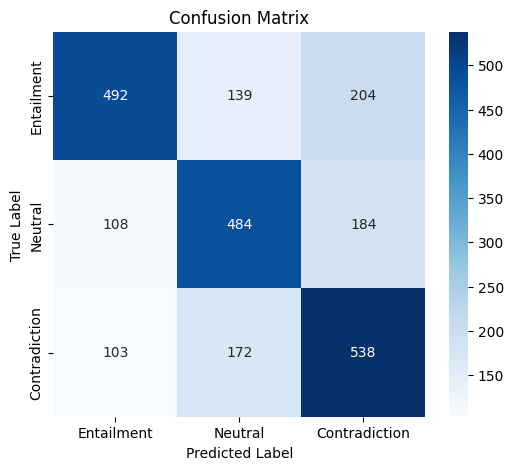

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, class_names):
    """Plots the Confusion Matrix."""
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Assuming all_preds and all_labels are stored after evaluation
plot_confusion_matrix(all_labels, all_preds, class_names=["Entailment", "Neutral", "Contradiction"])


# **Model Training(with tuned parameters and weights)**


 **Starting Epoch 1**...

 Batch 100: Loss = 0.0596
 Batch 200: Loss = 0.1323
 Batch 300: Loss = 0.5501
 Batch 400: Loss = 0.0215
 Batch 500: Loss = 0.0778
 Batch 600: Loss = 0.3340

✅ Epoch 1 Completed: Train Loss = 0.1889

🔹 Validation Loss = 1.4841
 Accuracy: 0.6019
               precision    recall  f1-score   support

   Entailment       0.72      0.50      0.59       835
      Neutral       0.64      0.53      0.58       776
Contradiction       0.52      0.77      0.62       813

     accuracy                           0.60      2424
    macro avg       0.63      0.60      0.60      2424
 weighted avg       0.63      0.60      0.60      2424



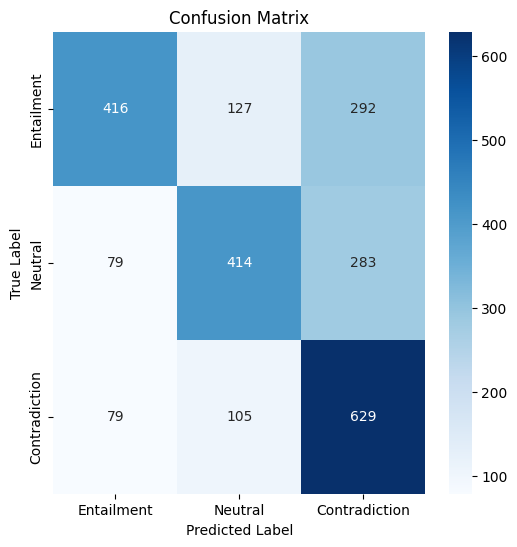

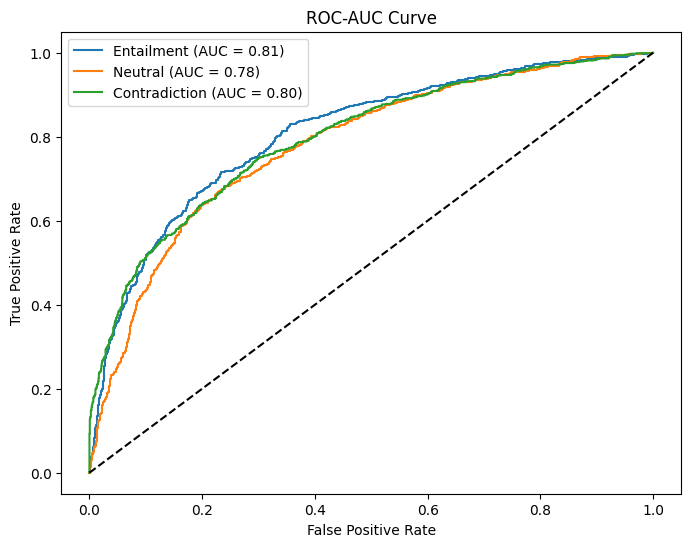


 **Starting Epoch 2**...

 Batch 100: Loss = 0.0286
 Batch 200: Loss = 0.3377
 Batch 300: Loss = 0.0266
 Batch 400: Loss = 0.0543
 Batch 500: Loss = 0.0427
 Batch 600: Loss = 0.1857

✅ Epoch 2 Completed: Train Loss = 0.1445

🔹 Validation Loss = 1.5632
 Accuracy: 0.6188
               precision    recall  f1-score   support

   Entailment       0.69      0.60      0.64       835
      Neutral       0.55      0.73      0.62       776
Contradiction       0.65      0.53      0.58       813

     accuracy                           0.62      2424
    macro avg       0.63      0.62      0.62      2424
 weighted avg       0.63      0.62      0.62      2424



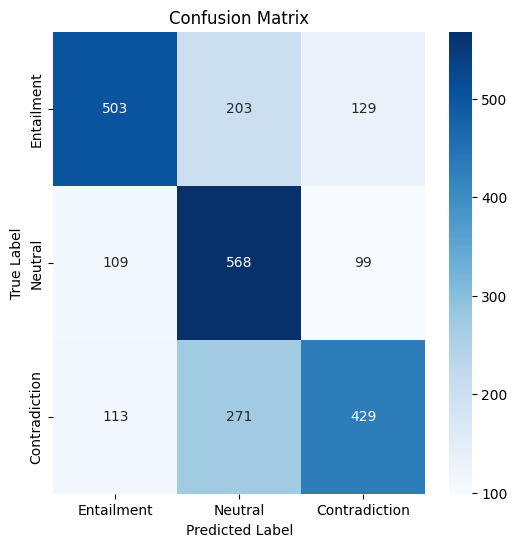

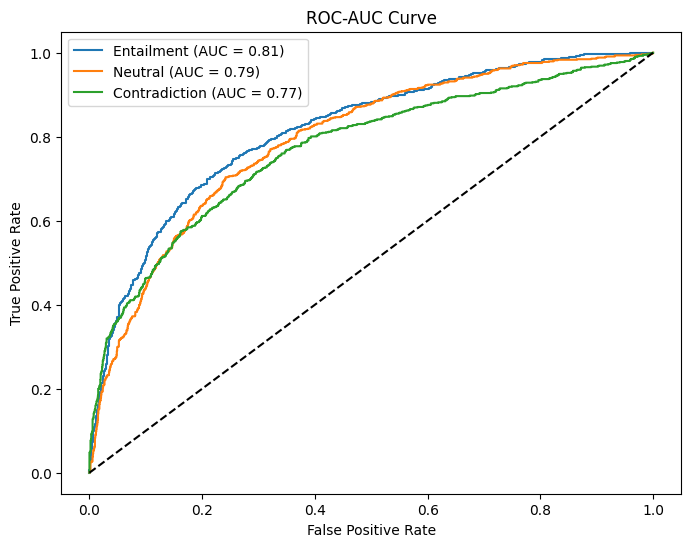


 **Starting Epoch 3**...

 Batch 100: Loss = 0.0266
 Batch 200: Loss = 0.5818
 Batch 300: Loss = 0.0342
 Batch 400: Loss = 0.0965
 Batch 500: Loss = 0.0103
 Batch 600: Loss = 0.0663

✅ Epoch 3 Completed: Train Loss = 0.1189

🔹 Validation Loss = 1.5825
 Accuracy: 0.6233
               precision    recall  f1-score   support

   Entailment       0.66      0.64      0.65       835
      Neutral       0.59      0.60      0.59       776
Contradiction       0.62      0.63      0.63       813

     accuracy                           0.62      2424
    macro avg       0.62      0.62      0.62      2424
 weighted avg       0.62      0.62      0.62      2424



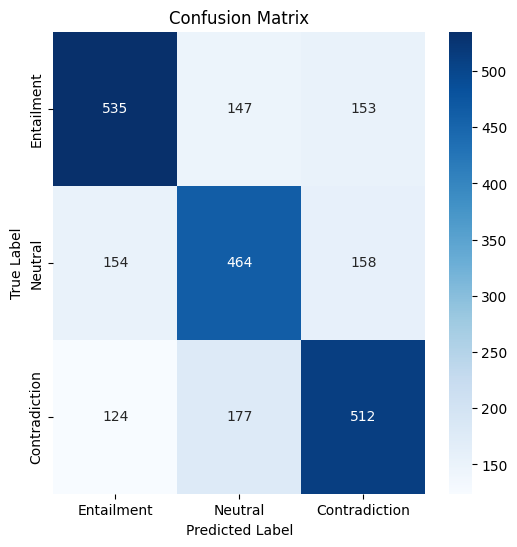

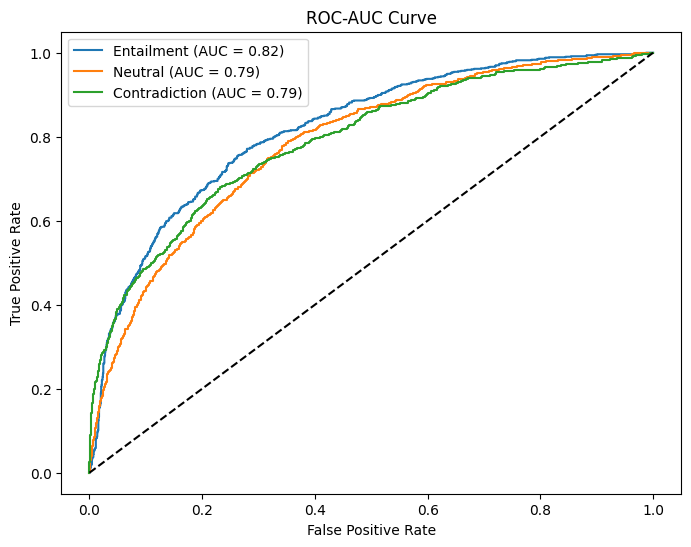


 **Starting Epoch 4**...

 Batch 100: Loss = 0.0069
 Batch 200: Loss = 0.0438
 Batch 300: Loss = 0.0775
 Batch 400: Loss = 0.0200
 Batch 500: Loss = 0.3294
 Batch 600: Loss = 0.0990

✅ Epoch 4 Completed: Train Loss = 0.0950

🔹 Validation Loss = 1.5846
 Accuracy: 0.6089
               precision    recall  f1-score   support

   Entailment       0.68      0.57      0.62       835
      Neutral       0.62      0.57      0.60       776
Contradiction       0.55      0.68      0.61       813

     accuracy                           0.61      2424
    macro avg       0.62      0.61      0.61      2424
 weighted avg       0.62      0.61      0.61      2424



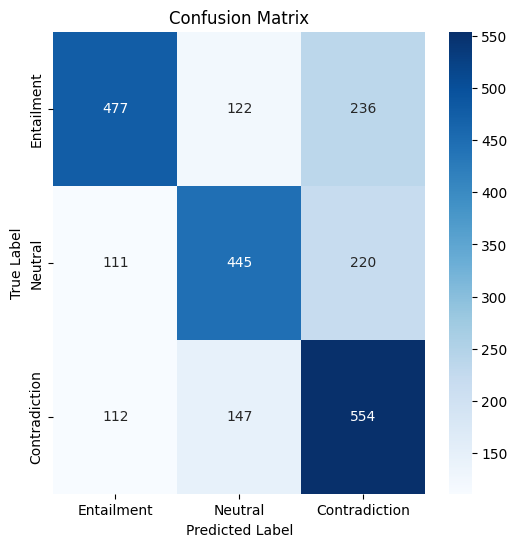

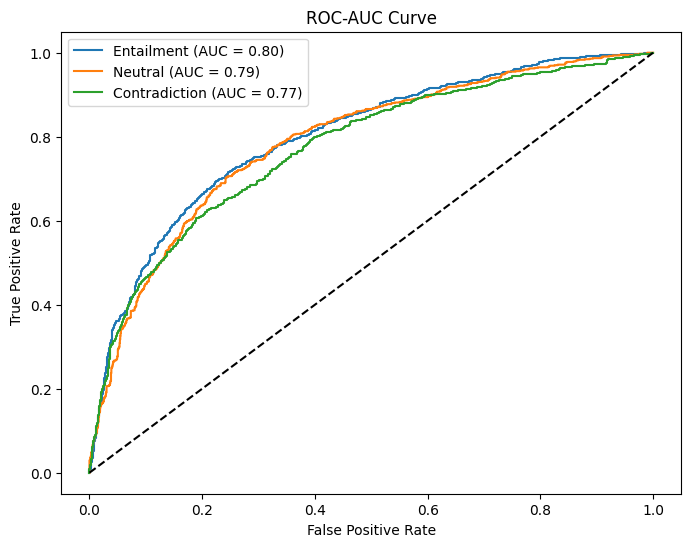


 **Starting Epoch 5**...

 Batch 100: Loss = 0.0073
 Batch 200: Loss = 0.0589
 Batch 300: Loss = 0.1013
 Batch 400: Loss = 0.1894
 Batch 500: Loss = 0.2471
 Batch 600: Loss = 0.2560

✅ Epoch 5 Completed: Train Loss = 0.0858

🔹 Validation Loss = 1.5648
 Accuracy: 0.6254
               precision    recall  f1-score   support

   Entailment       0.66      0.63      0.65       835
      Neutral       0.61      0.57      0.59       776
Contradiction       0.60      0.67      0.64       813

     accuracy                           0.63      2424
    macro avg       0.63      0.62      0.62      2424
 weighted avg       0.63      0.63      0.63      2424



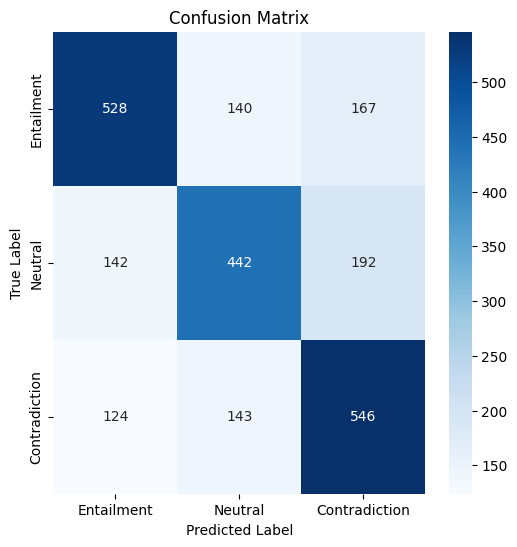

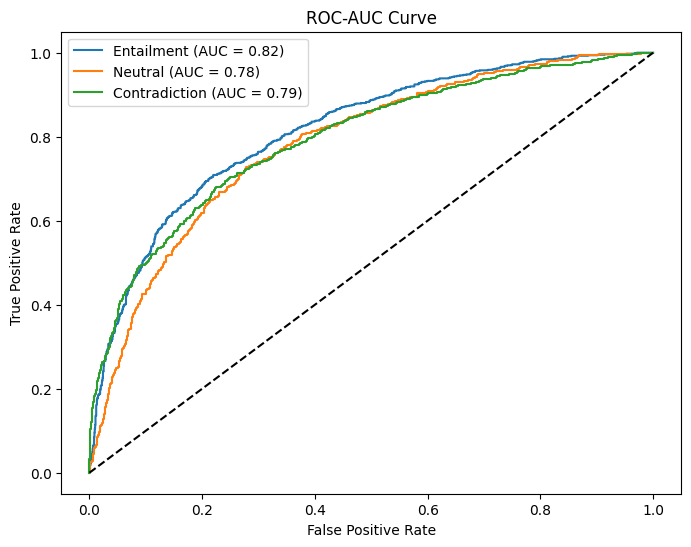


🎉 Training Completed Successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Training and Validation Loop
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\n **Starting Epoch {epoch+1}**...\n")

    # Training Loop
    model.train()
    total_train_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f" Batch {batch_idx + 1}: Loss = {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    print(f"\n✅ Epoch {epoch+1} Completed: Train Loss = {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()
    total_val_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)


            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

            # Compute probabilities
            probs = F.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())

            # Get predictions
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"\n🔹 Validation Loss = {avg_val_loss:.4f}")

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute performance metrics
    accuracy = np.mean(all_preds == all_labels)
    print(f" Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_preds, target_names=["Entailment", "Neutral", "Contradiction"]))

    # Plot Confusion Matrix
    def plot_confusion_matrix(y_true, y_pred, class_names):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    plot_confusion_matrix(all_labels, all_preds, class_names=["Entailment", "Neutral", "Contradiction"])

    # Plot AUC-ROC Curve
    def plot_roc_curve(y_true, y_probs, class_names):
        plt.figure(figsize=(8, 6))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--")  # Random chance line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC-AUC Curve")
        plt.legend()
        plt.show()

    plot_roc_curve(all_labels, all_probs, class_names=["Entailment", "Neutral", "Contradiction"])

print("\n🎉 Training Completed Successfully!")
